# Capstone: West Nile Virus

![chicago](images/chiskyline.png)

reference: [Kaggle Challenge 2015](https://www.kaggle.com/c/predict-west-nile-virus)

- West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.
- By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.
- Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.
- Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus.

# Import packages and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
#import plotly

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Load Datasets & feature selection

In [2]:
datadir = '../datasets'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored

## Datasets consist of Main, Spray, Weather, Map data:
- Main Data
    - test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 
- Spray Data
    - spraying to kill mosquitos.
    - the GIS data for their spray efforts in 2011 and 2013.
    - Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 
- Weather Data
    - It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.
    - dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 
- Map Data
    - primarily provided for use in visualizations

In [99]:
''' load the datasets '''

# load the main datasets that contain virus test results
train_merged  = pd.read_csv(os.path.join(datadir_pr, 'train_merged.csv'), parse_dates=['Date'], index_col='Date')
train_targets = pd.read_csv(os.path.join(datadir_pr, 'train_targets.csv'), parse_dates=['Date'], index_col='Date')

test_merged   = pd.read_csv(os.path.join(datadir_pr, 'test_merged.csv'), parse_dates=['Date'], index_col='Date')

In [100]:
train_merged.head(3)

,Block,AddressAccuracy,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,...,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,41,9,0,0,88,60,74.0,10.0,58,65.0,...,421.0,1917.0,0.0,29.39,30.11,5.8,18,6.5,2007,5
2007-05-29,41,9,0,1,88,60,74.0,10.0,58,65.0,...,421.0,1917.0,0.0,29.39,30.11,5.8,18,6.5,2007,5
2007-05-29,62,9,0,1,88,60,74.0,10.0,58,65.0,...,421.0,1917.0,0.0,29.39,30.11,5.8,18,6.5,2007,5


In [101]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Block                   10506 non-null  int64  
 1   AddressAccuracy         10506 non-null  int64  
 2   Species_CULEX PIPIENS   10506 non-null  int64  
 3   Species_CULEX RESTUANS  10506 non-null  int64  
 4   Tmax                    10506 non-null  int64  
 5   Tmin                    10506 non-null  int64  
 6   Tavg                    10506 non-null  float64
 7   Depart                  10506 non-null  float64
 8   DewPoint                10506 non-null  int64  
 9   WetBulb                 10506 non-null  float64
 10  Heat                    10506 non-null  float64
 11  Cool                    10506 non-null  float64
 12  Sunrise                 10506 non-null  float64
 13  Sunset                  10506 non-null  float64
 14  PrecipTotal          

In [102]:
train_targets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   NumMosquitos  10506 non-null  int64
 1   WnvPresent    10506 non-null  int64
dtypes: int64(2)
memory usage: 246.2 KB


In [103]:
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101948 entries, 2008-06-11 to 2014-10-02
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Block                   101948 non-null  int64  
 1   AddressAccuracy         101948 non-null  int64  
 2   Species_CULEX PIPIENS   101948 non-null  int64  
 3   Species_CULEX RESTUANS  101948 non-null  int64  
 4   Tmax                    101948 non-null  int64  
 5   Tmin                    101948 non-null  int64  
 6   Tavg                    101948 non-null  float64
 7   Depart                  101948 non-null  float64
 8   DewPoint                101948 non-null  int64  
 9   WetBulb                 101948 non-null  float64
 10  Heat                    101948 non-null  float64
 11  Cool                    101948 non-null  float64
 12  Sunrise                 101948 non-null  float64
 13  Sunset                  101948 non-null  float64
 14  Prec

# Split the merged training data into train & test
- **NOTE** that the dataframe called `test` is new data which will be applied for the final outcome. This `test` dataset has no information of `WnvPresent` and `NumMosquitos`.
- train dataset will be splitted into tr_train and tr_test for building and testing a model

In [104]:
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(train_merged, targets.WnvPresent, test_size=0.3, random_state=23)

In [105]:
''' Check whether the data is equally splited '''
print('Virus Positive ratio')
print('train: {}'.format(y_tr_train.sum()/len(y_tr_train)))
print('test:  {}'.format(y_tr_test.sum()/len(y_tr_test)))

Virus Positive ratio
train: 0.051944519989121564
test:  0.053616751269035534


In [106]:
X_tr_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7354 entries, 2009-07-13 to 2013-07-12
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Block                   7354 non-null   int64  
 1   AddressAccuracy         7354 non-null   int64  
 2   Species_CULEX PIPIENS   7354 non-null   int64  
 3   Species_CULEX RESTUANS  7354 non-null   int64  
 4   Tmax                    7354 non-null   int64  
 5   Tmin                    7354 non-null   int64  
 6   Tavg                    7354 non-null   float64
 7   Depart                  7354 non-null   float64
 8   DewPoint                7354 non-null   int64  
 9   WetBulb                 7354 non-null   float64
 10  Heat                    7354 non-null   float64
 11  Cool                    7354 non-null   float64
 12  Sunrise                 7354 non-null   float64
 13  Sunset                  7354 non-null   float64
 14  PrecipTotal           

In [107]:
X_tr_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3152 entries, 2007-06-26 to 2013-08-08
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Block                   3152 non-null   int64  
 1   AddressAccuracy         3152 non-null   int64  
 2   Species_CULEX PIPIENS   3152 non-null   int64  
 3   Species_CULEX RESTUANS  3152 non-null   int64  
 4   Tmax                    3152 non-null   int64  
 5   Tmin                    3152 non-null   int64  
 6   Tavg                    3152 non-null   float64
 7   Depart                  3152 non-null   float64
 8   DewPoint                3152 non-null   int64  
 9   WetBulb                 3152 non-null   float64
 10  Heat                    3152 non-null   float64
 11  Cool                    3152 non-null   float64
 12  Sunrise                 3152 non-null   float64
 13  Sunset                  3152 non-null   float64
 14  PrecipTotal           

In [108]:
y_tr_train.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 7354 entries, 2009-07-13 to 2013-07-12
Series name: WnvPresent
Non-Null Count  Dtype
--------------  -----
7354 non-null   int64
dtypes: int64(1)
memory usage: 114.9 KB


# Scaling

In [75]:
scaler = StandardScaler()
#scaler.fit(X_tr_train)
X_tr_train_scaled = scaler.fit_transform(X_tr_train)
X_tr_test_scaled  = scaler.transform(X_tr_test)

# Test Modeling 1: Logistic Regression

In [76]:
LogReg = LogisticRegression(solver='newton-cg', max_iter=1000)

In [77]:
LogReg.fit(X_tr_train_scaled, y_tr_train)

LogisticRegression(max_iter=1000, solver='newton-cg')

In [78]:
y_tr_test_predict = LogReg.predict(X_tr_test_scaled)

In [79]:
print("Accuracy score (y_tr_test_predict, y_tr_test): {}".format(accuracy_score(y_tr_test_predict, y_tr_test)))

Accuracy score (y_tr_test_predict, y_tr_test): 0.9463832487309645


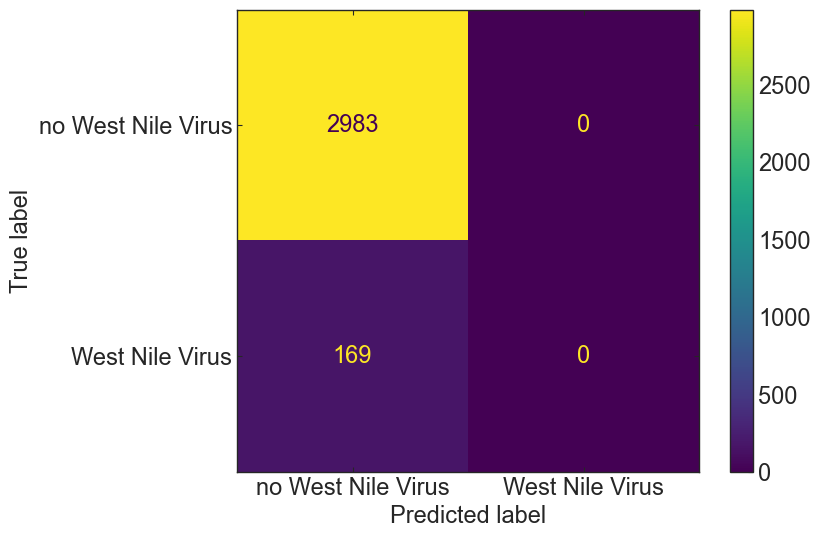

In [80]:
''' plot the confusion matrix '''
cm = confusion_matrix(y_tr_test, y_tr_test_predict, labels = LogReg.classes_)
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no West Nile Virus', 'West Nile Virus'])
fig, ax = plt.subplots()
display_cm.plot(ax=ax);

#ax.set_xticks([0, 1])
#ax.set_yticks([0, 1])
#ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
#ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8);

<div class='alert alert-danger'>
Note:
    
- Since the data is highly imbanaced, the first model with ***Logistic Regression*** was not successful.
</div>

# Test Modeling 2: Random Forest Classifier

In [81]:
Rand = RandomForestClassifier(random_state=42)

In [82]:
Rand.fit(X_tr_train_scaled, y_tr_train)

RandomForestClassifier(random_state=42)

In [83]:
y_tr_test_predict = Rand.predict(X_tr_test_scaled)

In [84]:
print("Accuracy score (y_tr_test_predict, y_tr_test): {}".format(accuracy_score(y_tr_test_predict, y_tr_test)))

Accuracy score (y_tr_test_predict, y_tr_test): 0.9270304568527918


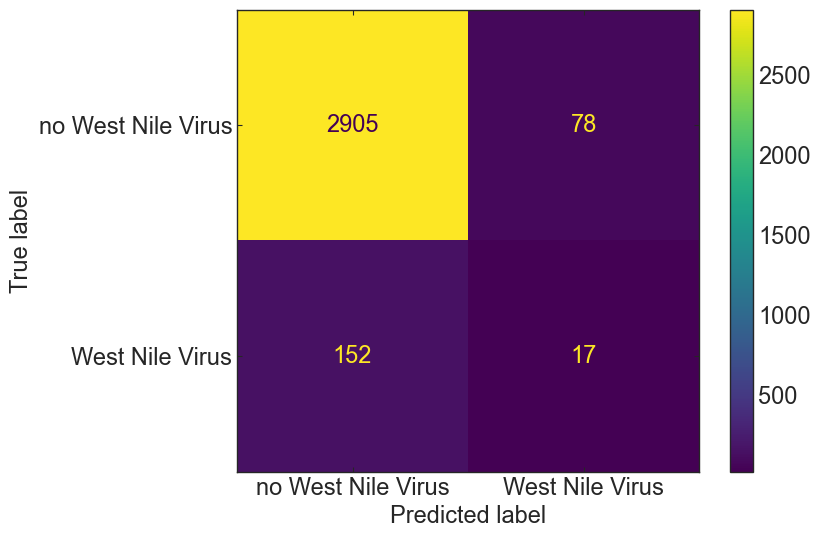

In [85]:
''' plot the confusion matrix '''
cm = confusion_matrix(y_tr_test, y_tr_test_predict, labels = LogReg.classes_)
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no West Nile Virus', 'West Nile Virus'])
fig, ax = plt.subplots()
display_cm.plot(ax=ax);

<div class='alert alert-danger'>
Note:
    
- The second model with ***Random Forest*** could detect some West Nile Virus, which is better than the result from the ***Logistic Regression***, but still the result is not good enough.
- We need to proceed over-sampling or under-sampling to resolve the problem with **imbalanced dataset**.
</div>

# Imbalanced Classification
- Oversampling for the minority feature (negative West Nile Virus)

In [86]:
print(Counter(targets.WnvPresent))

Counter({0: 9955, 1: 551})


In [87]:
# instantiating the random over sampler 
ros = RandomOverSampler()

# resampling X, y
X_ros, y_ros = ros.fit_resample(train_merged, targets.WnvPresent)

# new class distribution 
print(Counter(y_ros))

Counter({0: 9955, 1: 9955})


In [88]:
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X_ros, y_ros, test_size=0.3, random_state=23)

In [89]:
''' Check whether the data is equally splited '''
print('Virus Positive ratio')
print('train: {}'.format(y_tr_train.sum()/len(y_tr_train)))
print('test:  {}'.format(y_tr_test.sum()/len(y_tr_test)))

Virus Positive ratio
train: 0.4996053670086819
test:  0.5009208103130756


In [90]:
X_tr_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13937 entries, 13742 to 8787
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Block                   13937 non-null  int64  
 1   AddressAccuracy         13937 non-null  int64  
 2   Species_CULEX PIPIENS   13937 non-null  uint8  
 3   Species_CULEX RESTUANS  13937 non-null  uint8  
 4   Tmax                    13937 non-null  int64  
 5   Tmin                    13937 non-null  int64  
 6   Tavg                    13937 non-null  float64
 7   Depart                  13937 non-null  float64
 8   DewPoint                13937 non-null  int64  
 9   WetBulb                 13937 non-null  float64
 10  Heat                    13937 non-null  float64
 11  Cool                    13937 non-null  float64
 12  Sunrise                 13937 non-null  float64
 13  Sunset                  13937 non-null  float64
 14  PrecipTotal             13937 non-n

In [91]:
X_tr_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5973 entries, 6553 to 2089
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Block                   5973 non-null   int64  
 1   AddressAccuracy         5973 non-null   int64  
 2   Species_CULEX PIPIENS   5973 non-null   uint8  
 3   Species_CULEX RESTUANS  5973 non-null   uint8  
 4   Tmax                    5973 non-null   int64  
 5   Tmin                    5973 non-null   int64  
 6   Tavg                    5973 non-null   float64
 7   Depart                  5973 non-null   float64
 8   DewPoint                5973 non-null   int64  
 9   WetBulb                 5973 non-null   float64
 10  Heat                    5973 non-null   float64
 11  Cool                    5973 non-null   float64
 12  Sunrise                 5973 non-null   float64
 13  Sunset                  5973 non-null   float64
 14  PrecipTotal             5973 non-null

In [92]:
y_tr_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 13937 entries, 13742 to 8787
Series name: WnvPresent
Non-Null Count  Dtype
--------------  -----
13937 non-null  int64
dtypes: int64(1)
memory usage: 217.8 KB


## Scaling

In [93]:
scaler = StandardScaler()
#scaler.fit(X_tr_train)
X_tr_train_scaled = scaler.fit_transform(X_tr_train)
X_tr_test_scaled  = scaler.transform(X_tr_test)

## Test Modeling with the balanced dataset: Logistic Regression

In [94]:
LogReg = LogisticRegression(solver='newton-cg', max_iter=1000)

In [95]:
LogReg.fit(X_tr_train_scaled, y_tr_train)

LogisticRegression(max_iter=1000, solver='newton-cg')

In [96]:
y_tr_test_predict = LogReg.predict(X_tr_test_scaled)

In [97]:
print("Accuracy score (y_tr_test_predict, y_tr_test): {}".format(accuracy_score(y_tr_test_predict, y_tr_test)))

Accuracy score (y_tr_test_predict, y_tr_test): 0.7483676544450025


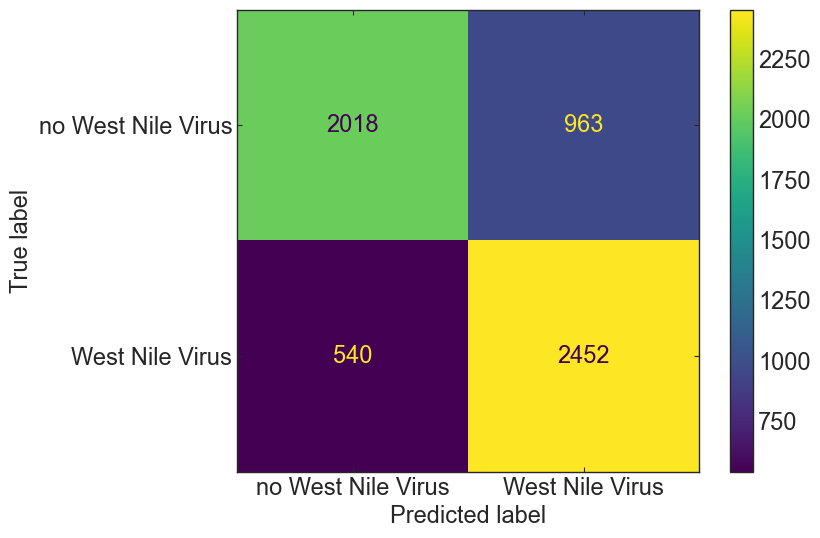

In [98]:
''' plot the confusion matrix '''
cm = confusion_matrix(y_tr_test, y_tr_test_predict, labels = LogReg.classes_)
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no West Nile Virus', 'West Nile Virus'])
fig, ax = plt.subplots()
display_cm.plot(ax=ax);

> - Now we could see that the model is greatly improved, and the balanced dataset is ready for building the models.
> - We will develop several models in the next step, and check the statistics and diagnostics like Receiver Operating Characteristics curve to find the best-bet one.

# Conclusion

In this preprocessing and feature engineering process, 
- re-checked the dataset and selected features of interest
- re-organized the categorical features by using one-hot code
- merged two separate datasets into one which would be used for modeling
- splitted the dataset into trainning and test ones 
- re-scaled (standardized) the dataset.

We found that the number of West Nile Virus positive cases is significantly smaller than that of negative cases (**Imblanced Classification**), the additional balancing process is demanded. 